# Importing the needed Libraries & Directories

Importing the required libraries and directories are important to avoid errors for it also allows the codes to work perfectly.

In [1]:
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import cv2
import json
import os
import matplotlib.pyplot as plt
import random
import seaborn as sns
import torch
from torch.nn import Sequential
from torch.nn import Conv2d, MaxPool2d, BatchNorm2d
from sklearn.model_selection import train_test_split
directory = "./face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/annotations"
image_directory = "./face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/images"
df = pd.read_csv("./face-mask-detection-dataset/train.csv")
df_test = pd.read_csv("./face-mask-detection-dataset/submission.csv")

In [2]:
#device management 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()
print(device)

cuda


# Importing SSD pretrained weights (Caffe Face Detector Model)

SSD or Single Shot Multibox Detector is used for detecting specific object in a given image. This SSD that I'm going to use is already pre-trained, which means although it has aquired some knowledge about its task, it still need to be trained (which I'll do later in the last lines of code for this project). 

In [3]:
cvNet = cv2.dnn.readNetFromCaffe('./caffe-face-detector-opencv-pretrained-model/architecture.txt','./caffe-face-detector-opencv-pretrained-model/weights.caffemodel')

# Functions to be used

The lines of code below is the JSON Function. This function retrieves the json file from the training dataset which contains the bounding box data.

In [4]:
def getJSON(filePathandName):
    with open(filePathandName,'r') as f:
        return json.load(f)

Next function is the Gamma correction. When applied, the images will get extra bright. For instance,  gamma < 1 will cause the image to get darker, and gamma > 1 will cause the image to be brighter.

In [5]:
def adjust_gamma(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)])
    return cv2.LUT(image.astype(np.uint8), table.astype(np.uint8))

# Pre-processing the Data

Data pre-processing is used for converting a raw data into a clean dataset.
Lets look at the JSON data given for training:

The Annotations Field contains all the information about the faces shown in a given image. There are different classnames but the only true classnames are face_with_mask and face_no_mask.

In [6]:
jsonfiles= []
for i in os.listdir(directory):
    jsonfiles.append(getJSON(os.path.join(directory,i)))
jsonfiles[0]

{'FileName': '2310.png',
 'NumOfAnno': 3,
 'Annotations': [{'isProtected': False,
   'ID': 81768340414106304,
   'BoundingBox': [213, 169, 325, 299],
   'classname': 'face_other_covering',
   'Confidence': 1,
   'Attributes': {}},
  {'isProtected': False,
   'ID': 613664631614999424,
   'BoundingBox': [171, 168, 346, 299],
   'classname': 'hijab_niqab',
   'Confidence': 1,
   'Attributes': {}},
  {'isProtected': False,
   'ID': 166231871773593440,
   'BoundingBox': [435, 183, 470, 223],
   'classname': 'face_no_mask',
   'Confidence': 1,
   'Attributes': {}}]}

In [7]:

df.head()

,name,x1,x2,y1,y2,classname
0,2756.png,69,126,294,392,face_with_mask
1,2756.png,505,10,723,283,face_with_mask
2,2756.png,75,252,264,390,mask_colorful
3,2756.png,521,136,711,277,mask_colorful
4,6098.jpg,360,85,728,653,face_no_mask


In [8]:
print(df["classname"].unique())

['face_with_mask' 'mask_colorful' 'face_no_mask'
 'face_with_mask_incorrect' 'mask_surgical' 'face_other_covering'
 'scarf_bandana' 'eyeglasses' 'helmet' 'face_shield' 'sunglasses' 'hood'
 'hat' 'goggles' 'hair_net' 'hijab_niqab' 'other' 'gas_mask'
 'balaclava_ski_mask' 'turban']


The mask label and non-mask label are utilized to extract bounding box information from json files. The very purpose of the Training Process is to extract and save the label and the faces of the given image into the data list.

In [9]:
data = []
img_size = 124
mask = ['face_with_mask']
non_mask = ["face_no_mask"]
labels={'mask':0,'without mask':1}
for i in df["name"].unique():
    f = i+".json"
    for j in getJSON(os.path.join(directory,f)).get("Annotations"):
        if j["classname"] in mask:
            x,y,w,h = j["BoundingBox"]
            img = cv2.imread(os.path.join(image_directory,i),1)
            img = img[y:h,x:w]
            img = cv2.resize(img,(img_size,img_size))
            data.append([img,labels["mask"]])
        if j["classname"] in non_mask:
            x,y,w,h = j["BoundingBox"]
            img = cv2.imread(os.path.join(image_directory,i),1)
            img = img[y:h,x:w]
            img = cv2.resize(img,(img_size,img_size))    
            data.append([img,labels["without mask"]])
random.shuffle(data)  



Checking how many objects are available in the given data.

In [10]:
len(data)

5749

Base on the visualization below, the Number of Mask images is greater than the Number of Non-Mask images which means its an imbalanced dataset.

<AxesSubplot:ylabel='count'>

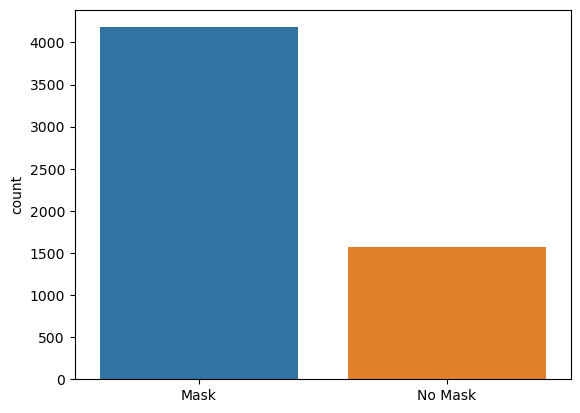

In [11]:
p = []
for face in data:
    if(face[1] == 0):
        p.append("Mask")
    else:
        p.append("No Mask")

sns.countplot(x=p)

The lines of code below is used for getting the shape of the features in the face mask data.

In [12]:
X = []
Y = []
for features,label in data:
    X.append(features)
    Y.append(label)


In [13]:
X[0].shape

(124, 124, 3)

The lines of code below is used for getting the labels in the face mask data.

In [14]:
X = np.array(X)/255.0
X = X.reshape(-1,124,124,3)
Y = np.array(Y)

In [15]:
np.unique(Y)

array([0, 1])

In [16]:
Y.shape

(5749,)

# Understanding the Model's Architecture and Training Process

The project's model architecture is only a rough abstraction. To start the training process we have to set the model to sequential first, after that we can start adding the needed attributes to the model.

In [17]:
import torch
import torch.nn as nn

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.maxpool = nn.MaxPool2d(2)
        self.dropout1 = nn.Dropout2d(0.25)
        self.flatten = nn.Flatten()
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128 * 30 * 30, 50)
        self.dropout3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(50, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.float()
        x = nn.ReLU()(self.conv1(x))
        x = nn.ReLU()(self.conv2(x))
        x = nn.ReLU()(self.conv3(x))
        x = self.maxpool(x)
        x = self.dropout1(x)
        x = self.flatten(x)
        x = self.dropout2(x)
        x = nn.ReLU()(self.fc1(x))
        x = self.dropout3(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

model = Model()

The line code below summarizes the model

In [18]:
#model.summary()
#print(summary(model, input_size=(BATCH_SIZE, 1,28,28), verbose=0))
model.to(device) 

Model(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=115200, out_features=50, bias=True)
  (dropout3): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=50, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

The line code below is for compiling the model by setting the loss to binary cross entropy, the optimizer to adam, and lastly, the metrics to accuracy.

In [19]:
#model.compile(loss='binary_crossentropy', optimizer='adam' ,metrics=['accuracy'])
from livelossplot import PlotLosses


def train_model(h5_file,train_dl, test_dl, model, loss_function,optimizer, scheduler, epochs):
    liveloss = PlotLosses()
    for epoch in range(epochs):
        logs = {}
        model.train()
        running_loss = 0.0
        for _, (inputs, _) in enumerate(train_dl):
            inputs = inputs.to(device)
            print(inputs.shape)
            outputs,_ = model(inputs)
            loss = loss_function(outputs, inputs)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        epoch_loss = running_loss / len(train_dl.dataset)
        logs['loss'] = epoch_loss*1000
        #Validation phase
        model.eval()
        running_loss = 0.0
        for inputs, labels in test_dl:
            inputs = inputs.to(device)
            outputs,_ = model(inputs)
            loss = loss_function(outputs, inputs)
            running_loss += loss.item()
        epoch_loss = running_loss / len(test_dl.dataset)
        logs['val_loss'] = epoch_loss*1000
        scheduler.step(epoch_loss) #callback a meio para atualizar lr
        epoch_lr = optimizer.param_groups[0]['lr']
        logs['val_lr'] = epoch_lr
        liveloss.update(logs) #para visualizarmos o processo de treino
        liveloss.send() #para visualizarmos o processo de treino
    torch.save(model,h5_file) 

Next, to get the xtrain, xval, ytrain, and yval, we have to use the train_test_split.

In [20]:



xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.2, random_state=42)



tensor1 = torch.tensor(xtrain)
tensor2 = torch.tensor(xtest)


print(tensor1.shape)
print(tensor2.shape)

tensor1 = tensor1.permute(0,3,1,2)
tensor2 = tensor2.permute(0,3,1,2)

train = torch.utils.data.TensorDataset( tensor1, torch.tensor(ytrain))
test = torch.utils.data.TensorDataset(tensor2, torch.tensor(ytest))

print(tensor1.shape)
print(tensor2.shape)





train_dl = DataLoader(train, batch_size=32, shuffle=True)
test_dl = DataLoader(test, batch_size=32, shuffle=True)





torch.Size([4599, 124, 124, 3])
torch.Size([1150, 124, 124, 3])
torch.Size([4599, 3, 124, 124])
torch.Size([1150, 3, 124, 124])


In [21]:
EPOCHS = 50
LEARNING_RATE = 0.001

from torch.nn import  BCELoss
from torch.optim import Adam 
from torch.optim.lr_scheduler import StepLR
import time
from livelossplot import PlotLosses

# definir o loss e a função de otimização
loss_function = BCELoss()
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
scheduler= StepLR(optimizer,step_size=10,gamma=0.95)
starttime = time.perf_counter()
train_model('./model.pth', train, test, model, loss_function, optimizer, scheduler, EPOCHS)
endtime = time.perf_counter()
print(f"Tempo gasto: {endtime - starttime} segundos")

AttributeError: 'Tensor' object has no attribute 'shpe'

Now, to generate the image data we have to use the image data generator. This is also to fit the xtrain to the data generation variable.

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,    
        rotation_range=15,    
        width_shift_range=0.1,
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=False)
datagen.fit(xtrain)

Now for the history variable, we have to store here the generated fit model along with 50 epochs which may take a while to load.

In [ ]:
history = model.fit_generator(datagen.flow(xtrain, ytrain, batch_size=32),
                    steps_per_epoch=xtrain.shape[0]//32,
                    epochs=50,
                    verbose=1,
                    validation_data=(xval, yval))

# Creating Visualisations for Training and Validation

The lines of code below creates a graph that differentiates the accuracy of training and validation of all the epochs that were created in the history variable.

In [ ]:
plt.plot(history.history['accuracy'],'g')
plt.plot(history.history['val_accuracy'],'b')
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Next, the lines of code below creates a graph that differentiates all the epochs' training and validation loss that were also created in the history variable.

In [ ]:
plt.plot(history.history['loss'],'g')
plt.plot(history.history['val_loss'],'b')
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Face Mask Detector Model Testing

Now for testing the Face Mask Detector Model, we'll have to use a few images from the dataset to be able to evaluate the model.

In [ ]:
print(len(df_test["name"]),len(df_test["name"].unique()))

test_images array is consisted of image names to be use for testing the model.

In [ ]:
test_images = ['1114.png','1504.jpg', '0072.jpg','0012.jpg','0353.jpg','1374.jpg']

Now, for presenting the results we have to set the gamma = 2, and then set the presentation size to 3 rows and 2 columns.

In [ ]:
gamma = 2.0
fig = plt.figure(figsize = (14,14))
rows = 3
cols = 2
axes = []
assign = {'0':'Mask','1':"No Mask"}
for j,im in enumerate(test_images):
    image =  cv2.imread(os.path.join(image_directory,im),1)
    image =  adjust_gamma(image, gamma=gamma)
    (h, w) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300,300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    cvNet.setInput(blob)
    detections = cvNet.forward()
    for i in range(0, detections.shape[2]):
        try:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            frame = image[startY:endY, startX:endX]
            confidence = detections[0, 0, i, 2]
            if confidence > 0.2:
                im = cv2.resize(frame,(img_size,img_size))
                im = np.array(im)/255.0
                im = im.reshape(1,124,124,3)
                result = model.predict(im)
                if result>0.5:
                    label_Y = 1
                else:
                    label_Y = 0
                cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
                cv2.putText(image,assign[str(label_Y)] , (startX, startY-10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (36,255,12), 2)
        
        except:pass
    axes.append(fig.add_subplot(rows, cols, j+1))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

# Conclusion

Looking at the results, we can see that the whole system performs well when faces have spatial dominance, such as shown in the images at (1,1), (1,2), and (2,1). But it can also be seen that the model fails to detect small faces and take up less space in the overall image which can be seen in (2,2). For better results, you can use 3 different methods such as using the different image preprocessing techniques, or keep the confidence threshold low, or by trying different blob sizes. 